In [25]:
import os
import glob
import pandas as pd
import numpy as np

X_unit = 180
Y_unit = 500
num_features = 4

def process_excel_files(directory):
    X_train_list = []
    Y_train_list = []

    # Loop through each Excel file in the directory
    for filepath in glob.glob(os.path.join(directory, '*.xlsx')):
        # Read the Excel file
        df = pd.read_excel(filepath)
        
        # Include 'SOH' in the selected columns
        df_selected = df[['Ftr1(k)', 'Ftr2(k)', 'Ftr3(k)', 'log(sum(T))', 'SOH']]
        
        # Extract the data for X_train (0th to 200th rows)
        X_train = df_selected.iloc[0:X_unit][['Ftr1(k)', 'Ftr2(k)', 'Ftr3(k)', 'log(sum(T))']].values
        
        # Extract the data for Y_train (0th to 500th rows)
        Y_train = df_selected.iloc[0:Y_unit]['SOH'].values
        
        # Append the data to the lists
        X_train_list.append(X_train)
        Y_train_list.append(Y_train)

    # Convert the lists to arrays
    X_train = np.array(X_train_list)
    Y_train = np.array(Y_train_list)

    return X_train, Y_train

X_train, Y_train = process_excel_files('.../train_set')
X_test, Y_test = process_excel_files('.../test_set')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.regularizers import l2

# Define the model
model = Sequential()

# Flatten the input to match the expected input of Dense layers
model.add(Flatten(input_shape=(X_unit, num_features)))

# Add the first dense layer with 256 units and L2 regularization
model.add(Dense(256, activation='elu', kernel_regularizer=l2(0.0001)))

# Add the second dense layer with 128 units and L2 regularization
model.add(Dense(128, activation='elu', kernel_regularizer=l2(0.0001)))

# Add the third dense layer with 64 units and L2 regularization
model.add(Dense(64, activation='elu', kernel_regularizer=l2(0.0001)))

# Add the final output layer with 900 units
model.add(Dense(Y_unit))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Fit the model to the training data
history = model.fit(X_train, Y_train, epochs=500, batch_size=1, validation_data=(X_test, Y_test))

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test, Y_test)

# Display the training history and test evaluation results
print(history.history)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

model.save('.../model.h5')


1/1 [==============================] - 0s 11ms/step


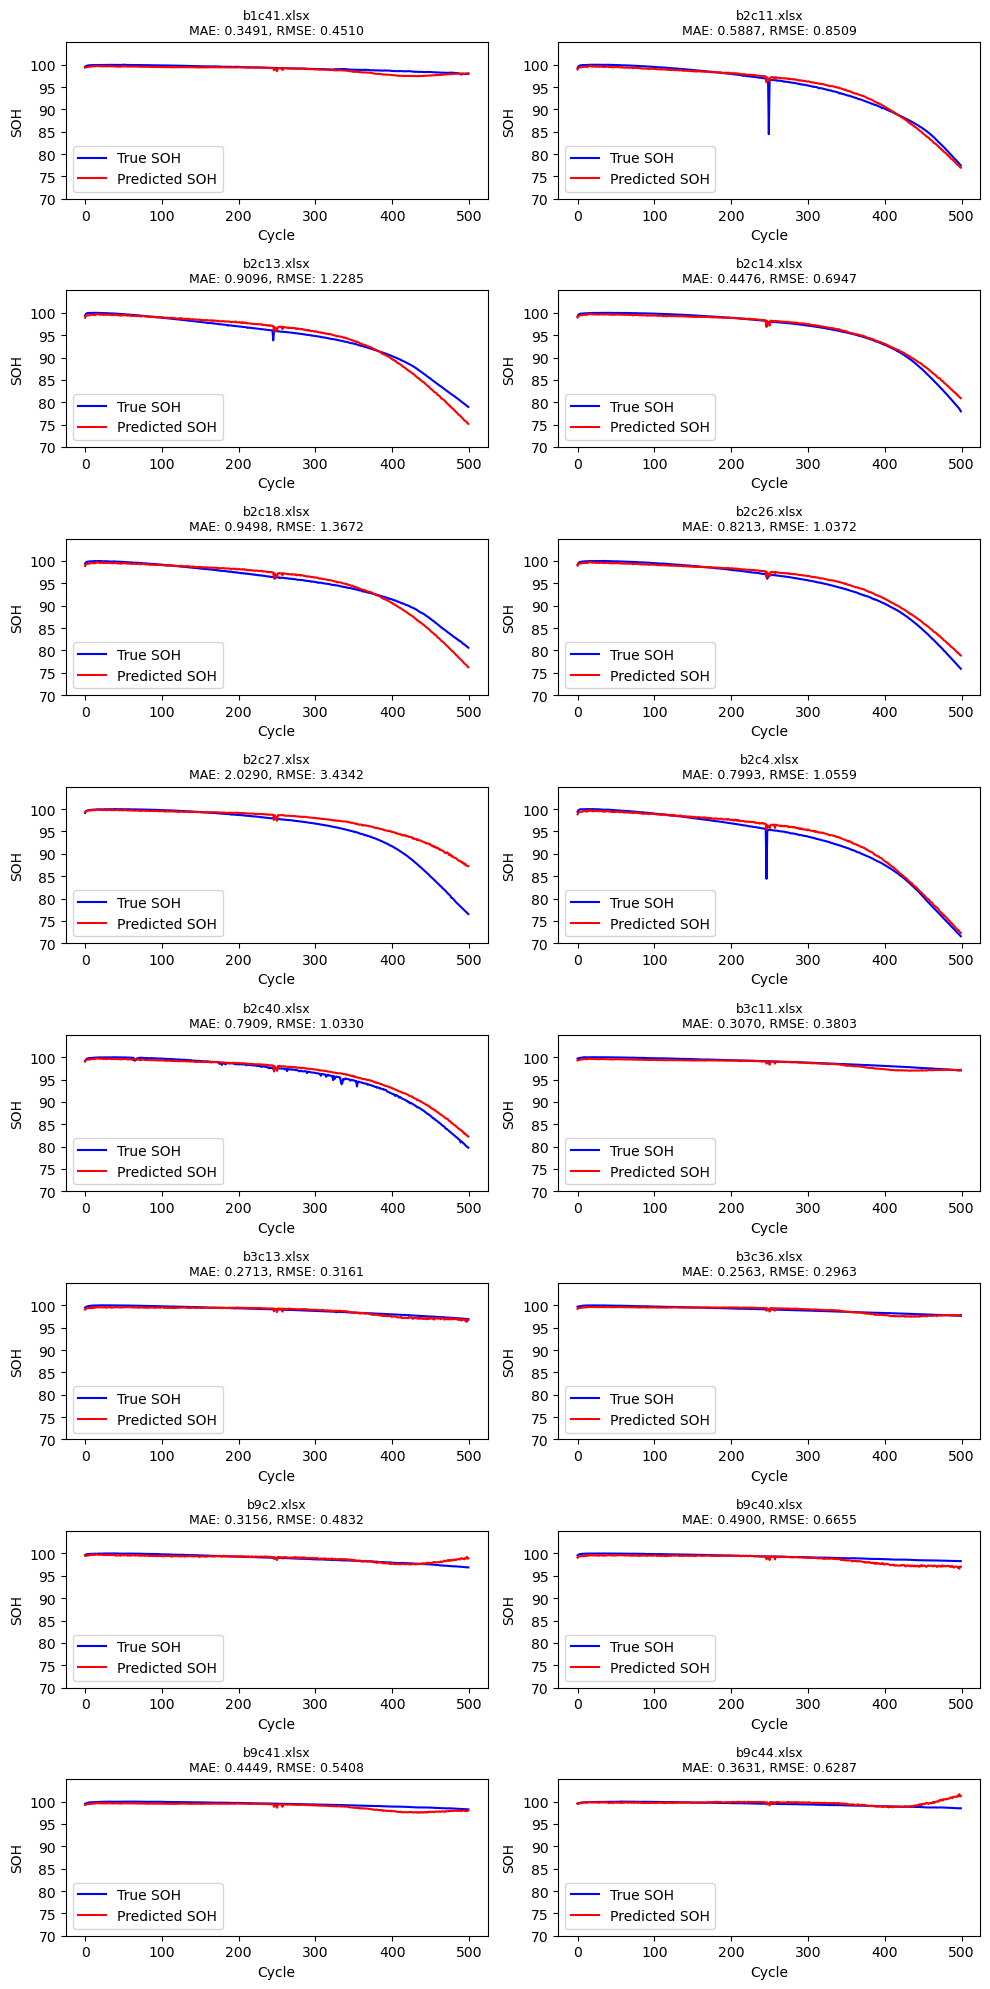

In [27]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ---------------------
# USER-SPECIFIC SETTINGS
# ---------------------
model_path = '.../model.h5'
pred_directory = '.../test_set'
save_path = '.../result.pdf'

# Set how many rows to use for X and Y
X_unit = 180
Y_unit = 500

model = load_model(model_path)

def process_and_plot_file(ax, filepath):
    # Check if the file exists
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return

    # Read the Excel file
    df = pd.read_excel(filepath)
    
    # Extract columns
    df_selected = df[['Ftr1(k)', 'Ftr2(k)', 'Temperature', 'SOH', 'Ftr3(k)', 'log(sum(T))']]
    
    # Prepare X and Y data
    X_train = df_selected.iloc[0:X_unit][['Ftr1(k)', 'Ftr2(k)', 'Ftr3(k)', 'log(sum(T))']].values
    Y_train = df_selected.iloc[0:Y_unit]['SOH'].values
    
    # Reshape as needed for model prediction
    X_train = np.expand_dims(X_train, axis=0)
    
    # Predict
    Y_pred = model.predict(X_train)[0]  # [0] to unwrap the first (and only) batch dimension
    
    # Truncate in case predictions exceed data length
    Y_pred_truncated = Y_pred[:len(Y_train)]
    
    # Metrics
    mae = mean_absolute_error(Y_train, Y_pred_truncated)
    mse = mean_squared_error(Y_train, Y_pred_truncated)
    rmse = np.sqrt(mse)

    # Plot
    ax.plot(Y_train, label='True SOH', color='blue')
    ax.plot(Y_pred_truncated, label='Predicted SOH', color='red')
    
    # Labels and title
    ax.set_xlabel('Cycle')
    ax.set_ylabel('SOH')
    ax.set_title(
        f"{os.path.basename(filepath)}\n"
        f"MAE: {mae:.4f}, RMSE: {rmse:.4f}",
        fontsize=9
    )
    
    # 1) Set the overall y-range so there's space above 100…
    ax.set_ylim(70, 105)
    
    # 2) …then manually set ticks so that the top label is 100.
    ax.set_yticks([70, 75, 80, 85, 90, 95, 100])
    
    ax.legend()

# Collect .xlsx files
files = [f for f in os.listdir(pred_directory) if f.endswith('.xlsx')]
files.sort()  # Sort if you want a consistent ordering

# Setup subplots
fig, axs = plt.subplots(8, 2, figsize=(10, 20))
axs = axs.flatten()

# Plot each file in a separate subplot
for i, filename in enumerate(files):
    if i >= len(axs):
        break
    filepath = os.path.join(pred_directory, filename)
    process_and_plot_file(axs[i], filepath)

plt.tight_layout()
plt.savefig(save_path, format='pdf')
plt.show()
